In [1]:
import numpy as np
from scipy.integrate import solve_bvp
from matplotlib import pyplot as plt
import itertools
from tqdm.notebook import tqdm

from DroneUtils import *

In `DroneUtils.py`, we call the 12-dimensional state vector $\boldsymbol{\sigma}$ `state`, and the 12-dimensional costate vector $\mathbf{p}$ `costate`.

To set this up in `solve_bvp`, we will stack the state and costate into a 24 dimensional vector $\mathbf{y}$.

In summary,

$$
\begin{aligned}
    \mathbf{y} &= \begin{pmatrix} \boldsymbol{\sigma} \\ \mathbf{p} \end{pmatrix}, \\
    \boldsymbol{\sigma} &= \begin{pmatrix} \mathbf{s} \\ \dot{\mathbf{s}} \end{pmatrix}, \\
    \mathbf{s} &= \begin{pmatrix} x \\ y \\ z \\ \phi \\ \theta \\ \psi \end{pmatrix}, \\
    \mathbf{p} &= \begin{pmatrix} p_1 \\ \vdots \\ p_{12} \end{pmatrix}
\end{aligned}
$$

This is a boundary value problem, with the following boundary conditions:

$$
\boldsymbol{\sigma}(0) = \left( x_0, y_0, z_0, \phi_0, \theta_0, \psi_0, \dot{x}_0, \dot{y}_0, \dot{z}_0, \dot{\phi}_0, \dot{\theta}_0, \dot{\psi}_0 \right)
$$

$$
\boldsymbol{\sigma}(t_f) = \mathbf{0}
$$

In [3]:
from tqdm import tqdm
import itertools

lambda_range = [1, 10, 100, 1000]
alpha_range = [1, 10, 100, 1000]

params = list(itertools.product(lambda_range, alpha_range))
pbar = tqdm(params)

for lambda_, alpha in pbar:
    pbar.set_description(f"Processing lambda: {lambda_}, alpha: {alpha}")

    sigma_init = np.array([
        1,       # Initial x
        3,       # Initial y 
        2,       # Initial z
        np.pi/8, # Initial phi
        np.pi/7, # Initial theta
        np.pi/6, # Initial psi
        0,       # Initial x velocity
        0,       # Initial y velocity
        0,       # Initial z velocity
        0,       # Initial phi velocity
        0,       # Initial theta velocity
        0        # Initial psi velocity
    ])

    sigma_final = np.zeros_like(sigma_init)

    count = 0

    def ode(time, y):
        global count 
        count += 1
        state = y[:12]   # First half is state evolution
        costate = y[12:] # Second half is costate evolution

        state_prime_matrix = np.array([
            state_prime(state[:, t], costate[:, t], lambda_)
            for t in range(len(time))
        ]).T

        costate_prime_matrix = np.array([
            costate_prime(state[:, t], costate[:, t], alpha, lambda_)
            for t in range(len(time))
        ]).T

        result = np.vstack([
            state_prime_matrix,
            costate_prime_matrix
        ])
        return result

    def bc(y_init, y_final):
        state_init = y_init[:12] 
        state_final = y_final[:12] 
        return np.hstack([
            state_init - sigma_init,
            state_final - sigma_final
        ])

    timesteps = 10
    t_range = np.linspace(0, 1, timesteps)
    sigma_guess = np.linspace(sigma_init, sigma_final, timesteps).T
    y_guess = np.vstack([
        sigma_guess,
        0.1 * np.ones((12, timesteps))
    ])

    sol = solve_bvp(
        ode,
        bc,
        t_range,
        y_guess
    )

    if sol.status != 2:
        print('success')
        print(lambda_)
        print(alpha)
        print()
        break


Processing lambda: 1, alpha: 1:   0%|          | 0/16 [00:00<?, ?it/s]

Processing lambda: 1, alpha: 10:   6%|▋         | 1/16 [00:01<00:24,  1.67s/it]

In [5]:
sol.status

2

In [6]:
count

55

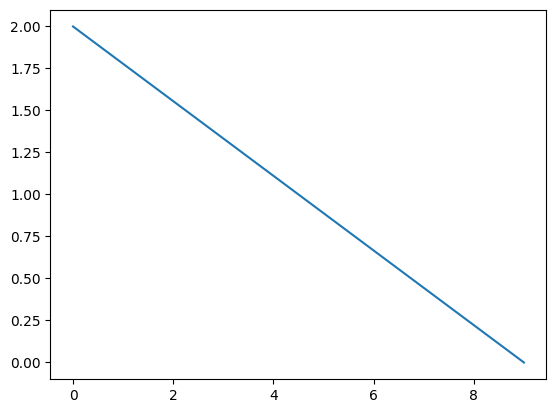

In [7]:
y_sol = sol.y

plt.plot(y_sol[2])
plt.show()